# Detection of Symmetry Protected Topological Phases in 1D

This notebook reproduces the tensor network results from the paper: ["Detection of Symmetry Protected Topological Phases in 1D" by Frank Pollmann and Ari M. Turner, Physical Review B 86, 125441 (2012)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.86.125441), freely available at [arXiv:1204.0704 [cond-mat.str-el]](https://arxiv.org/abs/1204.0704).

The paper is about identifying symmetry protected topological phases using matrix product states, i.e. phases that can be characterized using projective representations of their symmetry groups. Intrinsic topological phases are long-range entangled, have topologically protected boundary conditions, and exhibit fractionalization of charge, e.g. the fractional quantum Hall effect and the toric code. In contrast, symmetry protected topological phases are short-range entangled, have symmetry-protected boundary excitations, and exhibit "fractionalization" of symmetries, e.g. topological insulators and the Haldane chain (studied here).

We consider an example of bosonic symmetry protected topological phases in 1D. Specifically, we take a spin-1 chain described by the anisotropic Heisenberg model:

$$ H=J\sum_i \mathbf{S}_i\cdot\mathbf{S}_{i+1} + B \sum_i S_i^x + D \sum_i (S_i^z)^2,  $$

where $J$ is the coupling strength, $B$, $D$ are on-site anisotropies, and $\mathbf{S}=(S^x,S^y,S^z)$ is a vector of Pauli spins. We consider an infinite 1D chain with an initial ansatz of the Néel antiferromagnet. In the paper, they study this model using the infinite time evolving block decimation algorithm, however here we will use the infinite density matrix renormalization group.

## Method

To begin, we briefly outline the method. Further details can be found in the paper. 

We start with a product state ansatz wavefunction of up and down spins arranged as an antiferromagnet. We then apply the infinite density matrix renormalization group algorithm (or any other suitable algorithm) to obtain the ground-state wavefunction in an infinite matrix product state form, as shown in canoncial $\Lambda-\Gamma$ form in Fig. 1.(a). Now we know that if $|\Psi\rangle$ is invariant under an internal symmetry, $\Sigma$, then the matrix product state cannot change (up to a phase): $\Sigma_{jj'}\Gamma_{j'}=e^{i \theta}U^\dagger \Gamma_j U$. For a symmetry element $g$, the matrices $U_g$ form a projective representation of the symmetry group.

For example, for inversion symmetry $\mathcal{I}\Rightarrow\Gamma_{j}^{\intercal}=e^{i\theta}U_{\mathcal{I}}\Gamma_j U_{\mathcal{I}}$. Hence, we can distinguish symmetry protected topological phases simply by checking whether $U_{\mathcal{I}}U_{\mathcal{I}}^*=\pm\mathbf{1}$. In short: we need to compute the $U$ matrices to detect symmetry protected topological phases.

To this end, we employ the generalized (right) transfer matrix:

$$ T^\Sigma_{\alpha\alpha';\beta\beta'}=\sum_{j} \left( \sum_{j'} \Sigma_{jj'} \tilde{\Gamma}_{j',\alpha\beta} \right) \Gamma^*_{j,\alpha'\beta'} \Lambda_{\beta} \Lambda_{\beta'}, $$

which differs from the conventional transfer matrix simply the fact that one of the states to transformed by our internal symmetry transformation $\Sigma$. The overlap of the symmetry tranformation with (right) Schmidt states corresponds to applying the generalized transfer matrix many times. Hence, only the dominant eigenvector (with eigenvalue=1) survives in the thermodynamic limit. Futhermore, this dominant eigenvector is related to $U$ due to the symmetry transformation.

$$ T^{\Sigma}_{\alpha\alpha';\beta\beta'} X_{\beta\beta'} = \eta X_{\alpha\alpha'} \xrightarrow{\text{for }|\eta|=1}\boxed{U_{\beta\beta'}=X^*_{\beta\beta'}} $$

## Figure 4

To keep things simple, we can set $J=1$, $B=0$ and check if any phases are protected by inversion symmetry. In this case, we are interested in the inversion order parameter:

$$ \mathcal{O}_\mathcal{I}=\frac{1}{\chi}\text{tr}(U_\mathcal{I}U^*_\mathcal{I}) \;\;\;\text{if }|\eta_{\mathcal{I}}|=1, $$

and $0$ otherwise, which is what we will now compute. 

First, we can define the Heisenberg model...

In [106]:
from tenpy.models.model import CouplingMPOModel
from tenpy.networks.site import SpinSite
from tenpy.models.lattice import Chain


class HeisenbergModel(CouplingMPOModel):

    def __init__(self, params):
        CouplingMPOModel.__init__(self, params)

    def init_sites(self, params):
        site = SpinSite(S=1, conserve=None)
        return site

    def init_lattice(self, params):
        L = params.get('L', 6)
        site = self.init_sites(params)
        lat = Chain(L, site, bc='periodic', bc_MPS='infinite')
        return lat

    def init_terms(self, params):
        J = params.get('J', 1.)
        B = params.get('B', 0.)
        D = params.get('D', 1.)
        for u in range(len(self.lat.unit_cell)):
            self.add_onsite(B, u, 'Sx')
            self.add_onsite(D, u, 'Sz Sz')
        for u1, u2, dx in self.lat.pairs['nearest_neighbors']:
            self.add_coupling((J + J) / 4., u1, 'Sp', u2, 'Sm', dx, plus_hc=True)
            self.add_coupling((J - J) / 4., u1, 'Sp', u2, 'Sp', dx, plus_hc=True)
            self.add_coupling(J, u1, 'Sz', u2, 'Sz', dx)

...and the spatial inversion operator:

In [107]:
def spatial_inversion(self):
    """Perform a spatial inversion along the MPS.
    Exchanges the first with the last tensor and so on,
    i.e., exchange site `i` with site ``L-1 - i``.
    This is equivalent to a mirror/reflection with the bond left of L/2 (even L) or the site
    (L-1)/2 (odd L) as a fixpoint.
    For infinite MPS, the bond between MPS unit cells is another fix point.
    """
    self.sites = self.sites[::-1]
    self.form = [(f if f is None else (f[1], f[0])) for f in self.form[::-1]]
    self._B = [
        B.replace_labels(['vL', 'vR'], ['vR', 'vL']).transpose(self._B_labels)
        for B in self._B[::-1]
    ]
    self._S = self._S[::-1]
    self.test_sanity()
    return self

Next, we can compute the ground state wavefunction as we vary $D$.

WARNING: The following cell may take several minutes to run.

In [108]:
import numpy as np
import tenpy.linalg.np_conserved as npc

from tenpy.networks.mps import TransferMatrix
from tenpy.networks.site import SpinSite

from tenpy.networks.mps import MPS
from tenpy.algorithms import dmrg


data1 = dict(D_ext=np.linspace(-2, 2, 41), entropy=[], O_I=[], O_Z2xZ2=[])

model_params = dict(B=0)

dmrg_params = {
    'mixer': True, # setting this to True helps to escape local minima
    'mixer_params': {'amplitude': 1.e-5, 'decay': 1.2, 'disable_after': 30},
    'trunc_params': {
        # 'chi_max': 100,
        'svd_min': 1.e-10,
    },
    'lanczos_params': {
            # 'reortho': True,
            # 'N_cache': 40
            'cutoff': 1.e-13  # fixes theta=0 error
    },
    'chi_list': {0: 9, 10: 49, 20: 100, 40: 100},
    'max_E_err': 1.e-6,
    'max_S_err': 1.e-6,
    'max_sweeps': 1000,
    'verbose': 1.,
    'N_sweeps_check': 10,  # default=10
    'diag_method': 'default',
    'combine': True
}

prod_state = ['up', 'down']*3

eng = None
for D_ext in np.linspace(-2, 2, 41):
    print("="*100)
    print("D_ext = ", D_ext)
    model_params['D'] = D_ext
    if eng is None:  # first time in the loop
        M = HeisenbergModel(model_params)
        psi = MPS.from_product_state(M.lat.mps_sites(), prod_state, bc=M.lat.bc_MPS)
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    else:
        del eng.options['chi_list']
        M = HeisenbergModel(model_params)
        eng.init_env(model=M)
    E, psi = eng.run()
    
    ### compute S
    
    data1['entropy'].append(psi.entanglement_entropy()[0])
    
    ### compute O_I
    
    psi_t = psi.copy()
    psi_t = spatial_inversion(psi_t)
    TM = TransferMatrix(psi, psi_t, transpose=False, charge_sector=None)
    eta_I, w_I = TM.eigenvectors()
    UI = w_I[0].split_legs().to_ndarray().conj().T
    print("eta_I, UI.shape = ", eta_I, UI.shape)
    
    if UI.shape[0] != UI.shape[1]:
        raise ValueError("UI bond dimension mismatch.")
    
    if abs(np.max(eta_I)) > 0.99:
        O_I = np.real(np.trace(UI @ UI.conj()))  # spurious chi factor
    else:
        O_I = 0
        
    data1['O_I'].append(O_I)
    
    ### compute O_Z2xZ2
    
    site = SpinSite(S=1, conserve=None)
    
    # compute Ux
    sx = site.get_op('Sx')
    scaled_sx = sx.copy()
    scaled_sx.iscale_prefactor(1j * np.pi)
    Rx = npc.expm(scaled_sx)
    psi_t = psi.copy()
    for i in range(psi.L):
        psi_t.apply_local_op(i, Rx, renormalize=True)
    TM = TransferMatrix(psi, psi_t, transpose=False, charge_sector=None)
    eta_x, w_x = TM.eigenvectors()
    Ux = w_x[0].split_legs().to_ndarray().conj().T
    print("eta_x, Ux.shape = ", eta_x, Ux.shape)
        
    # compute Uz
    sz = site.get_op('Sz')
    scaled_sz = sz.copy()
    scaled_sz.iscale_prefactor(1j * np.pi)
    Rz = npc.expm(scaled_sz)
    psi_t = psi.copy()
    for i in range(psi.L):
        psi_t.apply_local_op(i, Rz, renormalize=True)
    TM = TransferMatrix(psi, psi_t, transpose=False, charge_sector=None)
    eta_z, w_z = TM.eigenvectors()
    Uz = w_z[0].split_legs().to_ndarray().conj().T
    print("eta_z, Uz.shape = ", eta_z, Uz.shape)

    if Ux.shape[0] != Uz.shape[0] or Ux.shape[1] != Uz.shape[1] or Ux.shape[0] != Uz.shape[1]:
        raise ValueError("Ux and Uz bond dimension mismatch.")

    if abs(eta_x) > 0.99 and abs(eta_z) > 0.99:
        O_Z2xZ2 = Ux.shape[0] * np.real(np.trace(Ux @ Uz @ Ux.conj().T @ Uz.conj().T))  # spurious chi^2 factor
    else:
        O_Z2xZ2 = 0
        
    data1['O_Z2xZ2'].append(O_Z2xZ2)

D_ext =  -2.0
Reading 'B'=0 for config HeisenbergModel
Reading 'D'=-2.0 for config HeisenbergModel
Reading 'combine'=True for config TwoSiteDMRGEngine
Subconfig 'lanczos_params'=Config(<2 options>, 'lanczos_params') for config TwoSiteDMRGEngine
Subconfig 'trunc_params'=Config(<2 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'chi_list'={0: 9, 10: 49, 20: 100, 40: 100} for config TwoSiteDMRGEngine
Setting chi_max = 9
Initial sweeps...
Updating environment
.
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'diag_method'='default' for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Setting chi_max = 49
Updating environment
.....
sweep 10, age = 198
Energy = -3.1497552586789461, S 

Updating environment
.....
sweep 50, age = 2742
Energy = -2.9593814257790050, S = 0.1376915038781592, norm_err = 1.6e-15
Current memory usage 375.0 MB, time elapsed: 45.3 s
Delta E = -4.6994e-13, Delta S = -3.1042e-14 (per sweep)
max_trunc_err = 6.6181e-20, max_E_trunc = 7.2760e-12
MPS bond dimensions: [97, 96, 97, 97, 97, 97]
DMRG finished after 50 sweeps.
total size = 2742, maximum chi = 97
eta_I, UI.shape =  [0.03361867+0.j] (97, 97)
eta_x, Ux.shape =  [0.03361867+5.35128826e-19j] (97, 97)
eta_z, Uz.shape =  [1.+5.13925382e-16j] (97, 97)
D_ext =  -1.7
Reading 'explicit_plus_hc'=False for config HeisenbergModel
Reading 'L'=6 for config HeisenbergModel
Reading 'J'=1.0 for config HeisenbergModel
Reading 'B'=0 for config HeisenbergModel
Reading 'D'=-1.7 for config HeisenbergModel
Reading 'sort_mpo_legs'=False for config HeisenbergModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 2934
Energy = -2.8646791909953513, S = nan, norm_err = 4.4e-15
Curren

Updating environment
.....
sweep 40, age = 5298
Energy = -2.6764223738709916, S = 0.1641063953200428, norm_err = 2.2e-15
Current memory usage 375.0 MB, time elapsed: 40.5 s
Delta E = 4.2442e-13, Delta S = -4.6044e-13 (per sweep)
max_trunc_err = 4.9596e-19, max_E_trunc = 1.8190e-11
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 50, age = 5478
Energy = -2.6764223738797832, S = 0.1641063953203977, norm_err = 1.8e-15
Current memory usage 375.0 MB, time elapsed: 46.8 s
Delta E = -8.7916e-13, Delta S = 3.5491e-14 (per sweep)
max_trunc_err = 4.9596e-19, max_E_trunc = 2.1828e-11
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
DMRG finished after 50 sweeps.
total size = 5478, maximum chi = 100
eta_I, UI.shape =  [0.05790824+0.j] (100, 100)
eta_x, Ux.shape =  [0.05790824-4.53180119e-17j] (100, 100)
eta_z, Uz.shape =  [1.+1.26770339e-16j] (100, 100)
D_ext =  -1.4
Reading 'explicit_plus_hc'=False for config HeisenbergModel
Reading 'L'=6 for config Heisenbe

disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 7854
Energy = -2.3976261512828692, S = 0.2005294471247095, norm_err = 2.1e-15
Current memory usage 375.0 MB, time elapsed: 31.4 s
Delta E = 1.0004e-12, Delta S = nan (per sweep)
max_trunc_err = 2.1348e-17, max_E_trunc = 5.0932e-11
MPS bond dimensions: [100, 100, 97, 100, 99, 99]
Updating environment
.....
sweep 40, age = 8034
Energy = -2.3976261512798374, S = 0.2005294471266010, norm_err = 1.3e-15
Current memory usage 375.0 MB, time elapsed: 37.6 s
Delta E = 3.0318e-13, Delta S = 1.8915e-13 (per sweep)
max_trunc_err = 9.2974e-18, max_E_trunc = 2.1828e-11
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 50, age = 8214
Energy = -2.3976261512880228, S = 0.2005294471257593, norm_err = 1.8e-15
Current memory usage 375.0 MB, time elapsed: 43.9 s
Delta E = -8.1855e-13, Delta S = -8.4174e-14 (per sweep)
max_trunc_err = 9.2974e-18, max_E_trunc = 7.2760e-12
MPS b

Updating environment
.....
sweep 20, age = 10410
Energy = -2.1248252776943750, S = nan, norm_err = 4.3e-15
Current memory usage 375.0 MB, time elapsed: 20.6 s
Delta E = -6.6698e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.0916e-16, max_E_trunc = 5.0932e-11
MPS bond dimensions: [93, 92, 93, 100, 100, 100]
disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 10590
Energy = -2.1248252776901304, S = 0.2545729818901150, norm_err = 2.4e-15
Current memory usage 375.0 MB, time elapsed: 29.4 s
Delta E = 4.2446e-13, Delta S = nan (per sweep)
max_trunc_err = 6.8677e-16, max_E_trunc = 2.9104e-11
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 40, age = 10770
Energy = -2.1248252776919494, S = 0.2545729818919166, norm_err = 2.0e-15
Current memory usage 375.0 MB, time elapsed: 35.9 s
Delta E = -1.8190e-13, Delta S = 1.8016e-13 (per sweep)
max_trunc_err = 2.8497e-16, max_E_trunc = 3.6380e-11
MPS bond dimensio

Reading 'sort_mpo_legs'=False for config HeisenbergModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 12966
Energy = -1.8613157234570583, S = nan, norm_err = 1.9e-14
Current memory usage 375.0 MB, time elapsed: 11.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.1175e-14, max_E_trunc = 7.6398e-11
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 20, age = 13146
Energy = -1.8613157234722166, S = nan, norm_err = 8.9e-15
Current memory usage 375.0 MB, time elapsed: 20.8 s
Delta E = -1.5158e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.0700e-14, max_E_trunc = 5.8208e-11
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 13326
Energy = -1.8613157234691851, S = 0.3482573675084983, norm_err = 7.4e-15
Current memory usage 375.0 MB, time elapsed: 28.9 s
Delta E = 3.0316e-13, Delta S = nan (per

eta_x, Ux.shape =  [0.76276555+6.5616677e-16j] (100, 100)
eta_z, Uz.shape =  [1.-2.83502456e-17j] (100, 100)
D_ext =  -0.2999999999999998
Reading 'explicit_plus_hc'=False for config HeisenbergModel
Reading 'L'=6 for config HeisenbergModel
Reading 'J'=1.0 for config HeisenbergModel
Reading 'B'=0 for config HeisenbergModel
Reading 'D'=-0.2999999999999998 for config HeisenbergModel
Reading 'sort_mpo_legs'=False for config HeisenbergModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 15702
Energy = -1.6149588073167251, S = nan, norm_err = 5.4e-03
Current memory usage 375.0 MB, time elapsed: 17.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.4926e-10, max_E_trunc = 9.6770e-10
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 20, age = 15882
Energy = -1.6149741665346180, S = nan, norm_err = 5.0e-03
Current memory usage 375.0 MB, time elapsed: 30.5 s
Delta E = -1.5359e-06, Delta S = 0.0000e+00 (per 

Updating environment
.....
sweep 50, age = 18774
Energy = -1.5405249972342669, S = 0.8853215153434540, norm_err = 1.5e-09
Current memory usage 375.0 MB, time elapsed: 40.6 s
Delta E = -2.2434e-12, Delta S = -2.3676e-12 (per sweep)
max_trunc_err = 7.4721e-11, max_E_trunc = 6.6939e-10
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
DMRG finished after 50 sweeps.
total size = 18774, maximum chi = 100
eta_I, UI.shape =  [1.+0.j] (100, 100)
eta_x, Ux.shape =  [1.-4.62292694e-16j] (100, 100)
eta_z, Uz.shape =  [1.-1.37638905e-18j] (100, 100)
D_ext =  -0.09999999999999987
Reading 'explicit_plus_hc'=False for config HeisenbergModel
Reading 'L'=6 for config HeisenbergModel
Reading 'J'=1.0 for config HeisenbergModel
Reading 'B'=0 for config HeisenbergModel
Reading 'D'=-0.09999999999999987 for config HeisenbergModel
Reading 'sort_mpo_legs'=False for config HeisenbergModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 18966
Energy = -1.4695303651672778, S 

Updating environment
.....
sweep 40, age = 21330
Energy = -1.3361332340785641, S = 0.8593858167368390, norm_err = 1.8e-12
Current memory usage 375.0 MB, time elapsed: 34.2 s
Delta E = -1.3339e-12, Delta S = 3.2923e-13 (per sweep)
max_trunc_err = 3.6075e-11, max_E_trunc = 3.6380e-10
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 50, age = 21510
Energy = -1.3361332340888719, S = 0.8593858167407101, norm_err = 2.8e-13
Current memory usage 375.0 MB, time elapsed: 40.2 s
Delta E = -1.0308e-12, Delta S = 3.8711e-13 (per sweep)
max_trunc_err = 3.6075e-11, max_E_trunc = 3.2742e-10
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
DMRG finished after 50 sweeps.
total size = 21510, maximum chi = 100
eta_I, UI.shape =  [1.+0.j] (100, 100)
eta_x, Ux.shape =  [1.+2.44589234e-16j] (100, 100)
eta_z, Uz.shape =  [1.-1.18815005e-16j] (100, 100)
D_ext =  0.20000000000000018
Reading 'explicit_plus_hc'=False for config HeisenbergModel
Reading 'L'=6 for config Heisen

disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 23886
Energy = -1.1549266466687793, S = 0.9091136337349068, norm_err = 1.3e-10
Current memory usage 375.0 MB, time elapsed: 34.0 s
Delta E = 6.6696e-13, Delta S = nan (per sweep)
max_trunc_err = 3.1910e-10, max_E_trunc = 1.3388e-09
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 40, age = 24066
Energy = -1.1549266467106161, S = 0.9091136337274169, norm_err = 1.4e-10
Current memory usage 375.0 MB, time elapsed: 40.9 s
Delta E = -4.1837e-12, Delta S = -7.4899e-13 (per sweep)
max_trunc_err = 1.5955e-10, max_E_trunc = 1.2369e-09
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 50, age = 24246
Energy = -1.1549266466906072, S = 0.9091136337171443, norm_err = 1.3e-10
Current memory usage 375.0 MB, time elapsed: 47.9 s
Delta E = 2.0009e-12, Delta S = -1.0273e-12 (per sweep)
max_trunc_err = 1.5955e-10, max_E_trunc = 1.2442e-0

Updating environment
.....
sweep 20, age = 26442
Energy = -0.9946457982781188, S = nan, norm_err = 7.0e-08
Current memory usage 375.0 MB, time elapsed: 24.1 s
Delta E = -1.4794e-11, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.8176e-09, max_E_trunc = 2.6404e-08
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 26622
Energy = -0.9946457982641732, S = 1.0434800371015969, norm_err = 8.3e-09
Current memory usage 375.0 MB, time elapsed: 33.6 s
Delta E = 1.3946e-12, Delta S = nan (per sweep)
max_trunc_err = 7.8212e-09, max_E_trunc = 2.6404e-08
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 40, age = 26802
Energy = -0.9946457982441643, S = 1.0434808328189604, norm_err = 3.3e-09
Current memory usage 375.0 MB, time elapsed: 40.6 s
Delta E = 2.0009e-12, Delta S = 7.9572e-08 (per sweep)
max_trunc_err = 3.9106e-09, max_E_trunc = 2.6470e-08
MPS bond dimens

Updating environment
.....
sweep 80, age = 29346
Energy = -0.8991435428106342, S = 1.3176428103017821, norm_err = 3.5e-07
Current memory usage 375.0 MB, time elapsed: 67.0 s
Delta E = 1.9403e-12, Delta S = -1.0283e-07 (per sweep)
max_trunc_err = 9.9397e-08, max_E_trunc = 6.3528e-07
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
DMRG finished after 80 sweeps.
total size = 29346, maximum chi = 100
eta_I, UI.shape =  [0.99999999+0.j] (100, 100)
eta_x, Ux.shape =  [1.+6.31797185e-17j] (100, 100)
eta_z, Uz.shape =  [1.+4.98975099e-17j] (100, 100)
D_ext =  1.0
Reading 'explicit_plus_hc'=False for config HeisenbergModel
Reading 'L'=6 for config HeisenbergModel
Reading 'J'=1.0 for config HeisenbergModel
Reading 'B'=0 for config HeisenbergModel
Reading 'D'=1.0 for config HeisenbergModel
Reading 'sort_mpo_legs'=False for config HeisenbergModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 29538
Energy = -0.8548286207975858, S = nan, norm_err = 1.3e-03
C

Updating environment
.....
sweep 180, age = 32598
Energy = -0.8548320109148335, S = 1.6657059801233585, norm_err = 2.4e-04
Current memory usage 375.0 MB, time elapsed: 138.1 s
Delta E = -1.2684e-10, Delta S = -1.2753e-05 (per sweep)
max_trunc_err = 4.2977e-07, max_E_trunc = 2.7908e-06
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 190, age = 32778
Energy = -0.8548320146195086, S = 1.6652641735510845, norm_err = 4.0e-04
Current memory usage 375.0 MB, time elapsed: 144.9 s
Delta E = -3.7047e-10, Delta S = -4.4181e-05 (per sweep)
max_trunc_err = 4.2969e-07, max_E_trunc = 2.7902e-06
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 200, age = 32958
Energy = -0.8548320256074172, S = 1.6639792449471154, norm_err = 6.9e-04
Current memory usage 375.0 MB, time elapsed: 151.6 s
Delta E = -1.0988e-09, Delta S = -1.2849e-04 (per sweep)
max_trunc_err = 4.2939e-07, max_E_trunc = 2.7881e-06
MPS bond dimensions: [100, 100, 100, 1

Updating environment
.....
sweep 380, age = 36198
Energy = -0.8548380477368482, S = 1.2385056977233191, norm_err = 1.6e-04
Current memory usage 375.0 MB, time elapsed: 279.1 s
Delta E = -1.8384e-10, Delta S = 4.7957e-04 (per sweep)
max_trunc_err = 1.0609e-07, max_E_trunc = 7.1150e-07
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 390, age = 36378
Energy = -0.8548380487760975, S = 1.2400413204184126, norm_err = 1.1e-04
Current memory usage 375.0 MB, time elapsed: 286.1 s
Delta E = -1.0392e-10, Delta S = 1.5356e-04 (per sweep)
max_trunc_err = 1.0684e-07, max_E_trunc = 7.1683e-07
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 400, age = 36558
Energy = -0.8548380493909159, S = 1.2418172088269159, norm_err = 1.1e-04
Current memory usage 375.0 MB, time elapsed: 293.2 s
Delta E = -6.1482e-11, Delta S = 1.7759e-04 (per sweep)
max_trunc_err = 1.0745e-07, max_E_trunc = 7.2095e-07
MPS bond dimensions: [100, 100, 100, 100,

Updating environment
.....
sweep 580, age = 39798
Energy = -0.8548380498735545, S = 1.2522721650335606, norm_err = 1.4e-04
Current memory usage 375.0 MB, time elapsed: 420.9 s
Delta E = -2.9710e-12, Delta S = 1.3953e-05 (per sweep)
max_trunc_err = 1.1169e-07, max_E_trunc = 7.4887e-07
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 590, age = 39978
Energy = -0.8548380498929570, S = 1.2523841831454403, norm_err = 1.3e-04
Current memory usage 375.0 MB, time elapsed: 427.8 s
Delta E = -1.9402e-12, Delta S = 1.1202e-05 (per sweep)
max_trunc_err = 1.1174e-07, max_E_trunc = 7.4924e-07
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 600, age = 40158
Energy = -0.8548380499093279, S = 1.2524865759838677, norm_err = 1.3e-04
Current memory usage 375.0 MB, time elapsed: 434.7 s
Delta E = -1.6371e-12, Delta S = 1.0239e-05 (per sweep)
max_trunc_err = 1.1179e-07, max_E_trunc = 7.4958e-07
MPS bond dimensions: [100, 100, 100, 100,

/home/bart/TeNPy/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG: norm_tol 1.00e-05 not reached by updating the environment, current norm_err = 2.81e-05
Call psi.canonical_form()
DMRG finished after 750 sweeps.
total size = 43158, maximum chi = 100
eta_I, UI.shape =  [0.99557305+0.j] (100, 100)
eta_x, Ux.shape =  [1.+7.84855009e-17j] (100, 100)
eta_z, Uz.shape =  [0.99557305+7.20613363e-17j] (100, 100)
D_ext =  1.1
Reading 'explicit_plus_hc'=False for config HeisenbergModel
Reading 'L'=6 for config HeisenbergModel
Reading 'J'=1.0 for config HeisenbergModel
Reading 'B'=0 for config HeisenbergModel
Reading 'D'=1.1 for config HeisenbergModel
Reading 'sort_mpo_legs'=False for config HeisenbergModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 43350
Energy = -0.8128426456896705, S = nan, norm_err = 6.8e-03
Current memory usage 375.0 MB, time elapsed: 12.4 s
Delta E = nan, Delta S = 0.0000e+00 (per s

/home/bart/TeNPy/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.....
Updating environment
.....
Updating environment
.....
Updating environment
.....
DMRG finished after 90 sweeps.
total size = 45030, maximum chi = 100
eta_I, UI.shape =  [0.99999995+0.j] (100, 100)
eta_x, Ux.shape =  [0.99999999+5.95965227e-17j] (100, 100)
eta_z, Uz.shape =  [0.99999997+2.2318505e-16j] (100, 100)
D_ext =  1.2000000000000002
Reading 'explicit_plus_hc'=False for config HeisenbergModel
Reading 'L'=6 for config HeisenbergModel
Reading 'J'=1.0 for config HeisenbergModel
Reading 'B'=0 for config HeisenbergModel
Reading 'D'=1.2000000000000002 for config HeisenbergModel
Reading 'sort_mpo_legs'=False for config HeisenbergModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 45222
Energy = -0.7732509227741199, S = nan, norm_err = 1.5e-05
Current memory usage 375.0 MB, time elapsed: 11.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 8.6244e-09, max_E_trunc = 3.1796e-08
MPS bond dimensions: [100, 100, 100, 100, 100, 100]

Updating environment
.....
sweep 50, age = 47766
Energy = -0.7008665597204526, S = 0.8000588550367036, norm_err = 2.7e-10
Current memory usage 375.0 MB, time elapsed: 45.1 s
Delta E = 3.6380e-13, Delta S = -1.1208e-11 (per sweep)
max_trunc_err = 8.2523e-11, max_E_trunc = 8.0036e-10
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
DMRG finished after 50 sweeps.
total size = 47766, maximum chi = 100
eta_I, UI.shape =  [1.+0.j] (100, 100)
eta_x, Ux.shape =  [1.-5.35117194e-16j] (100, 100)
eta_z, Uz.shape =  [1.+4.126501e-16j] (100, 100)
D_ext =  1.5
Reading 'explicit_plus_hc'=False for config HeisenbergModel
Reading 'L'=6 for config HeisenbergModel
Reading 'J'=1.0 for config HeisenbergModel
Reading 'B'=0 for config HeisenbergModel
Reading 'D'=1.5 for config HeisenbergModel
Reading 'sort_mpo_legs'=False for config HeisenbergModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 47958
Energy = -0.6679689222946763, S = nan, norm_err = 1.1e-10
Current mem

Updating environment
.....
sweep 40, age = 50322
Energy = -0.6082996821035825, S = 0.6318365756637050, norm_err = 1.0e-11
Current memory usage 375.0 MB, time elapsed: 40.4 s
Delta E = 2.3040e-12, Delta S = -4.3904e-12 (per sweep)
max_trunc_err = 7.7984e-13, max_E_trunc = 1.0186e-10
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 50, age = 50502
Energy = -0.6082996821181345, S = 0.6318365757022795, norm_err = 6.2e-12
Current memory usage 375.0 MB, time elapsed: 47.9 s
Delta E = -1.4552e-12, Delta S = 3.8574e-12 (per sweep)
max_trunc_err = 7.7984e-13, max_E_trunc = 1.7462e-10
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
DMRG finished after 50 sweeps.
total size = 50502, maximum chi = 100
eta_I, UI.shape =  [1.+0.j] (100, 100)
eta_x, Ux.shape =  [1.+4.25576458e-16j] (100, 100)
eta_z, Uz.shape =  [1.+7.06234897e-16j] (100, 100)
D_ext =  1.8000000000000003
Reading 'explicit_plus_hc'=False for config HeisenbergModel
Reading 'L'=6 for config Heisenb

disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 52878
Energy = -0.5324909806210295, S = 0.5162416904721580, norm_err = 8.3e-13
Current memory usage 375.0 MB, time elapsed: 47.4 s
Delta E = 1.5765e-12, Delta S = nan (per sweep)
max_trunc_err = 2.6568e-14, max_E_trunc = 3.0559e-10
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 40, age = 53058
Energy = -0.5324909806210295, S = 0.5162416905038255, norm_err = 1.9e-12
Current memory usage 375.0 MB, time elapsed: 57.3 s
Delta E = 0.0000e+00, Delta S = 3.1668e-12 (per sweep)
max_trunc_err = 1.3090e-14, max_E_trunc = 1.4552e-10
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 50, age = 53238
Energy = -0.5324909806380068, S = 0.5162416904891615, norm_err = 1.8e-12
Current memory usage 375.0 MB, time elapsed: 67.5 s
Delta E = -1.6977e-12, Delta S = -1.4664e-12 (per sweep)
max_trunc_err = 1.3090e-14, max_E_trunc = 1.3097e-10

To get a feel for the model, we can plot the entanglement entropy as a function of $D$:

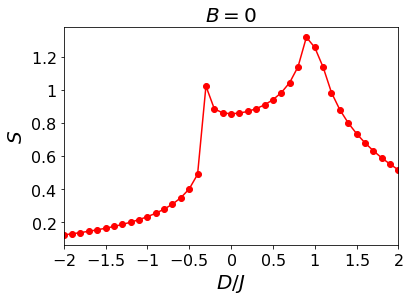

In [131]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.plot(data1['D_ext'], data1['entropy'], marker='o', c='r')
ax.set_xlabel(r"$D/J$", fontsize=20)
ax.set_ylabel(r"$S$", fontsize=20)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.set_xlim([-2, 2])
ax.set_title('$B=0$', fontsize=20)
plt.show()

From this plot, we can see that the entanglement entropy is diverging at $D/J\approx-0.3$ and $D/J\approx1$, which signals phase transitions. In order to find the nature of these different phases, we plot the inversion order parameter: 

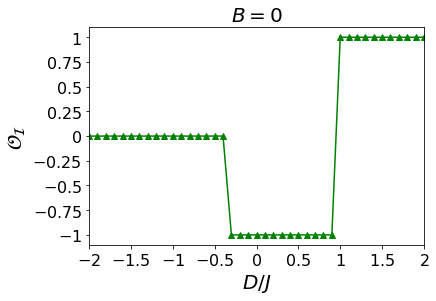

In [128]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.plot(data1['D_ext'], data1['O_I'], marker='^', c='g')
ax.set_xlabel(r"$D/J$", fontsize=20)
ax.set_ylabel(r"$\mathcal{O}_\mathcal{I}$", fontsize=20)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.set_xlim([-2, 2])
ax.set_title('$B=0$', fontsize=20)
plt.show()

This reproduces the $\mathcal{O}_\mathcal{I}$ curve from Fig.4.(a) in the paper. We can see that there are three distinct phases: there is the trivial phase between $-2\leq D/J < -0.3$, there is the Haldane phase between $-0.3 \leq D/J < 1$, and there is the large $D$ phase between $1\leq D/J < 2$. The Haldane and large $D$ regions are examples of symmetry protected topological phases and they can be discerned using our inversion order parameter. 

However, symmetry protected topological phases may be protected by more than one symmetry. Let us now analyze the $\mathbb{Z}_2\times\mathbb{Z}_2$ order parameter given as:

$$ \mathcal{O}_\mathcal{\mathbb{Z}_2\times\mathbb{Z}_2}=\frac{1}{\chi}\text{tr}(U_x U^*_z U_x U^*_z) \;\;\;\text{if }|\eta_{R_x}|=|\eta_{R_z}|=1, $$

and $0$ otherwise. We plot the $\mathbb{Z}_z\times\mathbb{Z}_2$ order parameter below:

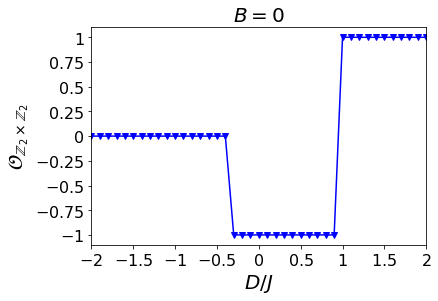

In [129]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.plot(data1['D_ext'], data1['O_Z2xZ2'], marker='v', c='b')
ax.set_xlabel(r"$D/J$", fontsize=20)
ax.set_ylabel(r"$\mathcal{O}_{\mathbb{Z}_2\times\mathbb{Z}_2}$", fontsize=20)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.set_xlim([-2, 2])
ax.set_title('$B=0$', fontsize=20)
plt.show()

This reproduces the $\mathcal{O}_{\mathbb{Z}_2\times\mathbb{Z}_2}$ curve in Fig. 4.(a) and corresponds to the $\mathcal{O}_\mathcal{I}$ result, showing that phases are protected by both this inversion and rotation symmetry.

To probe the phase diagram in Fig. 3 further we can analyze the slice at $B=0.3$.

WARNING: The following cell may take several minutes to run.

In [112]:
import numpy as np
import tenpy.linalg.np_conserved as npc

from tenpy.networks.mps import TransferMatrix
from tenpy.networks.site import SpinSite

from tenpy.networks.mps import MPS
from tenpy.algorithms import dmrg


data2 = dict(D_ext=np.linspace(-2, 2, 41), entropy=[], O_I=[], O_Z2xZ2=[])

model_params = dict(B=0.3)

dmrg_params = {
    'mixer': True, # setting this to True helps to escape local minima
    'mixer_params': {'amplitude': 1.e-5, 'decay': 1.2, 'disable_after': 30},
    'trunc_params': {
        # 'chi_max': 100,
        'svd_min': 1.e-10,
    },
    'lanczos_params': {
            # 'reortho': True,
            # 'N_cache': 40
            'cutoff': 1.e-13  # fixes theta=0 error
    },
    'chi_list': {0: 9, 10: 49, 20: 100, 40: 100},
    'max_E_err': 1.e-6,
    'max_S_err': 1.e-6,
    'max_sweeps': 1000,
    'verbose': 1.,
    'N_sweeps_check': 10,  # default=10
    'diag_method': 'default',
    'combine': True
}

prod_state = ['up', 'down']*3

eng = None
for D_ext in np.linspace(-2, 2, 41):
    print("="*100)
    print("D_ext = ", D_ext)
    model_params['D'] = D_ext
    if eng is None:  # first time in the loop
        M = HeisenbergModel(model_params)
        psi = MPS.from_product_state(M.lat.mps_sites(), prod_state, bc=M.lat.bc_MPS)
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    else:
        del eng.options['chi_list']
        M = HeisenbergModel(model_params)
        eng.init_env(model=M)
    E, psi = eng.run()
    
    ### compute O_I
    
    psi_t = psi.copy()
    psi_t = spatial_inversion(psi_t)
    TM = TransferMatrix(psi, psi_t, transpose=False, charge_sector=None)
    eta_I, w_I = TM.eigenvectors()
    UI = w_I[0].split_legs().to_ndarray().conj().T
    print("eta_I, UI.shape = ", eta_I, UI.shape)
    
    if UI.shape[0] != UI.shape[1]:
        raise ValueError("UI bond dimension mismatch.")
    
    if abs(np.max(eta_I)) > 0.99:
        O_I = np.real(np.trace(UI @ UI.conj()))  # spurious chi factor
    else:
        O_I = 0
        
    data2['O_I'].append(O_I)

D_ext =  -2.0
Reading 'B'=0.3 for config HeisenbergModel
Reading 'D'=-2.0 for config HeisenbergModel
Reading 'combine'=True for config TwoSiteDMRGEngine
Subconfig 'lanczos_params'=Config(<2 options>, 'lanczos_params') for config TwoSiteDMRGEngine
Subconfig 'trunc_params'=Config(<2 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'chi_list'={0: 9, 10: 49, 20: 100, 40: 100} for config TwoSiteDMRGEngine
Setting chi_max = 9
Initial sweeps...
Updating environment
.
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'diag_method'='default' for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Setting chi_max = 49
Updating environment
.....
sweep 10, age = 198
Energy = -3.1566139337383183, 

Updating environment
.....
sweep 50, age = 2742
Energy = -2.9663846404364449, S = 0.1370192236874381, norm_err = 3.4e-15
Current memory usage 375.0 MB, time elapsed: 75.1 s
Delta E = -3.0331e-14, Delta S = 3.9302e-15 (per sweep)
max_trunc_err = 6.1093e-20, max_E_trunc = 2.7285e-11
MPS bond dimensions: [96, 96, 97, 96, 96, 96]
DMRG finished after 50 sweeps.
total size = 2742, maximum chi = 97
eta_I, UI.shape =  [0.01355793-0.00777247j] (96, 96)
D_ext =  -1.7
Reading 'explicit_plus_hc'=False for config HeisenbergModel
Reading 'L'=6 for config HeisenbergModel
Reading 'J'=1.0 for config HeisenbergModel
Reading 'B'=0.3 for config HeisenbergModel
Reading 'D'=-1.7 for config HeisenbergModel
Reading 'sort_mpo_legs'=False for config HeisenbergModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 2934
Energy = -2.8717510636311090, S = nan, norm_err = 4.0e-15
Current memory usage 375.0 MB, time elapsed: 22.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max

Updating environment
.....
sweep 50, age = 5478
Energy = -2.6836194264475730, S = 0.1630570695510864, norm_err = 2.0e-15
Current memory usage 375.0 MB, time elapsed: 76.3 s
Delta E = -1.0609e-13, Delta S = 5.5367e-14 (per sweep)
max_trunc_err = 3.8173e-19, max_E_trunc = 2.1828e-11
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
DMRG finished after 50 sweeps.
total size = 5478, maximum chi = 100
eta_I, UI.shape =  [0.02287924-0.01016004j] (100, 100)
D_ext =  -1.4
Reading 'explicit_plus_hc'=False for config HeisenbergModel
Reading 'L'=6 for config HeisenbergModel
Reading 'J'=1.0 for config HeisenbergModel
Reading 'B'=0.3 for config HeisenbergModel
Reading 'D'=-1.4 for config HeisenbergModel
Reading 'sort_mpo_legs'=False for config HeisenbergModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 5670
Energy = -2.5902067747704982, S = nan, norm_err = 3.3e-15
Current memory usage 375.0 MB, time elapsed: 21.2 s
Delta E = nan, Delta S = 0.0000e+00 (per s

Updating environment
.....
sweep 50, age = 8214
Energy = -2.4049559027692644, S = 0.1986603169918223, norm_err = 2.6e-15
Current memory usage 375.0 MB, time elapsed: 70.5 s
Delta E = 4.2442e-13, Delta S = -1.1756e-13 (per sweep)
max_trunc_err = 5.2043e-18, max_E_trunc = -3.6380e-12
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
DMRG finished after 50 sweeps.
total size = 8214, maximum chi = 100
eta_I, UI.shape =  [0.04077692-0.01099856j] (100, 100)
D_ext =  -1.1
Reading 'explicit_plus_hc'=False for config HeisenbergModel
Reading 'L'=6 for config HeisenbergModel
Reading 'J'=1.0 for config HeisenbergModel
Reading 'B'=0.3 for config HeisenbergModel
Reading 'D'=-1.1 for config HeisenbergModel
Reading 'sort_mpo_legs'=False for config HeisenbergModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 8406
Energy = -2.3132540325113951, S = nan, norm_err = 4.4e-15
Current memory usage 375.0 MB, time elapsed: 19.2 s
Delta E = nan, Delta S = 0.0000e+00 (per 

Updating environment
.....
sweep 50, age = 10950
Energy = -2.1321427691934027, S = 0.2504497152905732, norm_err = 3.2e-15
Current memory usage 375.0 MB, time elapsed: 70.4 s
Delta E = 1.2430e-12, Delta S = -3.1807e-13 (per sweep)
max_trunc_err = 1.1764e-16, max_E_trunc = 5.4570e-11
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
DMRG finished after 50 sweeps.
total size = 10950, maximum chi = 100
eta_I, UI.shape =  [0.09456097+0.j] (100, 100)
D_ext =  -0.7999999999999998
Reading 'explicit_plus_hc'=False for config HeisenbergModel
Reading 'L'=6 for config HeisenbergModel
Reading 'J'=1.0 for config HeisenbergModel
Reading 'B'=0.3 for config HeisenbergModel
Reading 'D'=-0.7999999999999998 for config HeisenbergModel
Reading 'sort_mpo_legs'=False for config HeisenbergModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 11142
Energy = -2.0429708381507226, S = nan, norm_err = 5.0e-15
Current memory usage 375.0 MB, time elapsed: 19.1 s
Delta E = nan, De

Updating environment
.....
sweep 50, age = 13686
Energy = -1.8682221084563935, S = 0.3344917306565885, norm_err = 1.4e-15
Current memory usage 375.0 MB, time elapsed: 65.3 s
Delta E = 1.1520e-12, Delta S = -6.5061e-13 (per sweep)
max_trunc_err = 6.0651e-15, max_E_trunc = 5.8208e-11
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
DMRG finished after 50 sweeps.
total size = 13686, maximum chi = 100
eta_I, UI.shape =  [0.22873635+0.j] (100, 100)
D_ext =  -0.5
Reading 'explicit_plus_hc'=False for config HeisenbergModel
Reading 'L'=6 for config HeisenbergModel
Reading 'J'=1.0 for config HeisenbergModel
Reading 'B'=0.3 for config HeisenbergModel
Reading 'D'=-0.5 for config HeisenbergModel
Reading 'sort_mpo_legs'=False for config HeisenbergModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 13878
Energy = -1.7831250300696411, S = nan, norm_err = 4.9e-15
Current memory usage 375.0 MB, time elapsed: 18.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)

Updating environment
.....
sweep 50, age = 16422
Energy = -1.6193963899477239, S = 0.5121014315668408, norm_err = 5.4e-12
Current memory usage 375.0 MB, time elapsed: 71.6 s
Delta E = -1.8190e-13, Delta S = -1.0177e-13 (per sweep)
max_trunc_err = 2.6550e-12, max_E_trunc = 5.0932e-11
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
DMRG finished after 50 sweeps.
total size = 16422, maximum chi = 100
eta_I, UI.shape =  [0.61389347+0.j] (100, 100)
D_ext =  -0.19999999999999996
Reading 'explicit_plus_hc'=False for config HeisenbergModel
Reading 'L'=6 for config HeisenbergModel
Reading 'J'=1.0 for config HeisenbergModel
Reading 'B'=0.3 for config HeisenbergModel
Reading 'D'=-0.19999999999999996 for config HeisenbergModel
Reading 'sort_mpo_legs'=False for config HeisenbergModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 16614
Energy = -1.5421423733150732, S = nan, norm_err = 8.8e-05
Current memory usage 375.0 MB, time elapsed: 31.3 s
Delta E = nan,

Updating environment
.....
sweep 20, age = 19158
Energy = -1.4014840387317236, S = nan, norm_err = 9.8e-12
Current memory usage 375.0 MB, time elapsed: 34.1 s
Delta E = -2.3040e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.3449e-11, max_E_trunc = 3.2014e-10
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 19338
Energy = -1.4014840387244476, S = 0.8554980711090548, norm_err = 4.2e-12
Current memory usage 375.0 MB, time elapsed: 47.6 s
Delta E = 7.2760e-13, Delta S = nan (per sweep)
max_trunc_err = 7.3449e-11, max_E_trunc = 3.0559e-10
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 40, age = 19518
Energy = -1.4014840387153527, S = 0.8554980711086489, norm_err = 1.2e-12
Current memory usage 375.0 MB, time elapsed: 57.6 s
Delta E = 9.0949e-13, Delta S = -4.0590e-14 (per sweep)
max_trunc_err = 3.6725e-11, max_E_trunc = 3.4197e-10
MPS bond dimen

Updating environment
.....
sweep 20, age = 21894
Energy = -1.2139203404658474, S = nan, norm_err = 3.8e-10
Current memory usage 375.0 MB, time elapsed: 34.8 s
Delta E = -1.4552e-12, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.0899e-10, max_E_trunc = 2.1901e-09
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 22074
Energy = -1.2139203404652410, S = 0.9176151693827124, norm_err = 3.6e-10
Current memory usage 375.0 MB, time elapsed: 48.8 s
Delta E = 6.0640e-14, Delta S = nan (per sweep)
max_trunc_err = 6.0899e-10, max_E_trunc = 2.2119e-09
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 40, age = 22254
Energy = -1.2139203404634220, S = 0.9176151693742051, norm_err = 3.7e-10
Current memory usage 375.0 MB, time elapsed: 58.9 s
Delta E = 1.8190e-13, Delta S = -8.5073e-13 (per sweep)
max_trunc_err = 3.0450e-10, max_E_trunc = 2.1682e-09
MPS bond dimen

Updating environment
.....
sweep 20, age = 24630
Energy = -1.0484336313450815, S = nan, norm_err = 8.2e-05
Current memory usage 375.0 MB, time elapsed: 37.4 s
Delta E = -2.1955e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.9714e-08, max_E_trunc = 6.5978e-08
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 24810
Energy = -1.0484336436202284, S = 1.1240504232658710, norm_err = 1.9e-05
Current memory usage 375.0 MB, time elapsed: 52.0 s
Delta E = -1.2275e-09, Delta S = nan (per sweep)
max_trunc_err = 2.2831e-08, max_E_trunc = 7.6077e-08
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 40, age = 24990
Energy = -1.0484336443356976, S = 1.1249293714578761, norm_err = 6.5e-06
Current memory usage 375.0 MB, time elapsed: 61.7 s
Delta E = -7.1547e-11, Delta S = 8.7895e-05 (per sweep)
max_trunc_err = 1.1921e-08, max_E_trunc = 7.9461e-08
MPS bond dime

Updating environment
.....
sweep 220, age = 28230
Energy = -1.0484336442338342, S = 1.1253359436372430, norm_err = 5.0e-06
Current memory usage 375.0 MB, time elapsed: 244.9 s
Delta E = 1.2126e-13, Delta S = 1.5115e-05 (per sweep)
max_trunc_err = 1.2146e-08, max_E_trunc = 8.0945e-08
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 230, age = 28410
Energy = -1.0484336442010924, S = 1.1251696835760576, norm_err = 5.9e-06
Current memory usage 375.0 MB, time elapsed: 255.0 s
Delta E = 3.2742e-12, Delta S = -1.6626e-05 (per sweep)
max_trunc_err = 1.2157e-08, max_E_trunc = 8.0967e-08
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 240, age = 28590
Energy = -1.0484336442120064, S = 1.1253528605682932, norm_err = 6.1e-06
Current memory usage 375.0 MB, time elapsed: 264.9 s
Delta E = -1.0914e-12, Delta S = 1.8318e-05 (per sweep)
max_trunc_err = 1.2145e-08, max_E_trunc = 8.0887e-08
MPS bond dimensions: [100, 100, 100, 100, 

Updating environment
.....
sweep 420, age = 31830
Energy = -1.0484336441131745, S = 1.1250973619265829, norm_err = 1.1e-05
Current memory usage 375.0 MB, time elapsed: 452.2 s
Delta E = 8.5493e-12, Delta S = -3.0366e-05 (per sweep)
max_trunc_err = 1.2164e-08, max_E_trunc = 8.1091e-08
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 430, age = 32010
Energy = -1.0484336440828581, S = 1.1254357266293189, norm_err = 1.1e-05
Current memory usage 375.0 MB, time elapsed: 462.5 s
Delta E = 3.0316e-12, Delta S = 3.3836e-05 (per sweep)
max_trunc_err = 1.2143e-08, max_E_trunc = 8.0981e-08
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 440, age = 32190
Energy = -1.0484336440980162, S = 1.1250580020441399, norm_err = 1.3e-05
Current memory usage 375.0 MB, time elapsed: 472.4 s
Delta E = -1.5158e-12, Delta S = -3.7772e-05 (per sweep)
max_trunc_err = 1.2169e-08, max_E_trunc = 8.1054e-08
MPS bond dimensions: [100, 100, 100, 100,

Updating environment
.....
sweep 620, age = 35430
Energy = -1.0484336442593001, S = 1.1252840988526247, norm_err = 1.6e-06
Current memory usage 375.0 MB, time elapsed: 658.2 s
Delta E = -4.3656e-12, Delta S = 5.1078e-06 (per sweep)
max_trunc_err = 1.2148e-08, max_E_trunc = 8.1047e-08
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 630, age = 35610
Energy = -1.0484336442605127, S = 1.1252265844589318, norm_err = 2.2e-06
Current memory usage 375.0 MB, time elapsed: 668.0 s
Delta E = -1.2126e-13, Delta S = -5.7514e-06 (per sweep)
max_trunc_err = 1.2152e-08, max_E_trunc = 8.1011e-08
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 640, age = 35790
Energy = -1.0484336442629381, S = 1.1252897313279036, norm_err = 2.0e-06
Current memory usage 375.0 MB, time elapsed: 678.2 s
Delta E = -2.4254e-13, Delta S = 6.3147e-06 (per sweep)
max_trunc_err = 1.2148e-08, max_E_trunc = 8.1018e-08
MPS bond dimensions: [100, 100, 100, 100

Updating environment
.....
sweep 820, age = 39030
Energy = -1.0484336440931656, S = 1.1254488505293327, norm_err = 1.2e-05
Current memory usage 375.0 MB, time elapsed: 857.8 s
Delta E = 3.7592e-12, Delta S = 3.6266e-05 (per sweep)
max_trunc_err = 1.2143e-08, max_E_trunc = 8.0960e-08
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 830, age = 39210
Energy = -1.0484336440707314, S = 1.1250429364444556, norm_err = 1.4e-05
Current memory usage 375.0 MB, time elapsed: 865.7 s
Delta E = 2.2434e-12, Delta S = -4.0591e-05 (per sweep)
max_trunc_err = 1.2171e-08, max_E_trunc = 8.1345e-08
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 840, age = 39390
Energy = -1.0484336440373834, S = 1.1255007177434615, norm_err = 1.6e-05
Current memory usage 375.0 MB, time elapsed: 873.3 s
Delta E = 3.3348e-12, Delta S = 4.5778e-05 (per sweep)
max_trunc_err = 1.2143e-08, max_E_trunc = 8.0872e-08
MPS bond dimensions: [100, 100, 100, 100, 1

.
Updating environment
.....
sweep 10, age = 42462
Energy = -0.9979158320832843, S = nan, norm_err = 4.4e-03
Current memory usage 375.0 MB, time elapsed: 16.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.8291e-08, max_E_trunc = 1.6449e-07
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 20, age = 42642
Energy = -0.9979240758669524, S = nan, norm_err = 2.9e-03
Current memory usage 375.0 MB, time elapsed: 30.9 s
Delta E = -8.2438e-07, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 7.2378e-08, max_E_trunc = 2.4233e-07
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 42822
Energy = -0.9979263896323877, S = 1.4099676039830011, norm_err = 2.1e-03
Current memory usage 375.0 MB, time elapsed: 44.3 s
Delta E = -2.3138e-07, Delta S = nan (per sweep)
max_trunc_err = 8.7292e-08, max_E_trunc = 2.9217e-07
MPS bond dimensions: [100, 100, 10

/home/bart/TeNPy/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.....
Updating environment
.....
Updating environment
.....
DMRG finished after 100 sweeps.
total size = 44262, maximum chi = 100
eta_I, UI.shape =  [1.-3.66210389e-09j] (100, 100)
D_ext =  0.8000000000000003
Reading 'explicit_plus_hc'=False for config HeisenbergModel
Reading 'L'=6 for config HeisenbergModel
Reading 'J'=1.0 for config HeisenbergModel
Reading 'B'=0.3 for config HeisenbergModel
Reading 'D'=0.8000000000000003 for config HeisenbergModel
Reading 'sort_mpo_legs'=False for config HeisenbergModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 44454
Energy = -0.9496666824876835, S = nan, norm_err = 1.8e-05
Current memory usage 375.0 MB, time elapsed: 15.7 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.7685e-08, max_E_trunc = 2.0086e-07
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 20, age = 44634
Energy = -0.9496666999354298, S = nan, norm_err = 1.0e-06
Current memory usage 375.0 MB

DMRG finished after 50 sweeps.
total size = 46998, maximum chi = 100
eta_I, UI.shape =  [1.-9.0133566e-08j] (100, 100)
D_ext =  1.1
Reading 'explicit_plus_hc'=False for config HeisenbergModel
Reading 'L'=6 for config HeisenbergModel
Reading 'J'=1.0 for config HeisenbergModel
Reading 'B'=0.3 for config HeisenbergModel
Reading 'D'=1.1 for config HeisenbergModel
Reading 'sort_mpo_legs'=False for config HeisenbergModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 47190
Energy = -0.8177863498737376, S = nan, norm_err = 2.2e-04
Current memory usage 375.0 MB, time elapsed: 16.6 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5514e-08, max_E_trunc = 2.3068e-07
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 20, age = 47370
Energy = -0.8177865616186560, S = nan, norm_err = 4.6e-05
Current memory usage 375.0 MB, time elapsed: 31.1 s
Delta E = -2.1174e-08, Delta S = 0.0000e+00 (per sweep)
max_trunc_err

/home/bart/TeNPy/tenpy/algorithms/dmrg.py:408: UserWarning: final DMRG state not in canonical form within `norm_tol` = 1.00e-05
  warnings.warn(msg.format(nt=norm_tol))


.....
DMRG finished after 70 sweeps.
total size = 49422, maximum chi = 100
eta_I, UI.shape =  [1.0000005+0.j] (100, 100)
D_ext =  1.3000000000000003
Reading 'explicit_plus_hc'=False for config HeisenbergModel
Reading 'L'=6 for config HeisenbergModel
Reading 'J'=1.0 for config HeisenbergModel
Reading 'B'=0.3 for config HeisenbergModel
Reading 'D'=1.3000000000000003 for config HeisenbergModel
Reading 'sort_mpo_legs'=False for config HeisenbergModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 49614
Energy = -0.7413348448317265, S = nan, norm_err = 3.1e-06
Current memory usage 375.0 MB, time elapsed: 16.0 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 4.8886e-08, max_E_trunc = 1.7697e-07
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 20, age = 49794
Energy = -0.7413348457824517, S = nan, norm_err = 7.7e-07
Current memory usage 375.0 MB, time elapsed: 29.6 s
Delta E = -9.5073e-11, Delta S = 0.00

Updating environment
.....
sweep 60, age = 52338
Energy = -0.6739280757271141, S = 1.4168016510048211, norm_err = 2.1e-04
Current memory usage 375.0 MB, time elapsed: 73.9 s
Delta E = -9.7013e-12, Delta S = -6.1947e-06 (per sweep)
max_trunc_err = 2.1980e-09, max_E_trunc = 1.8044e-08
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 70, age = 52518
Energy = -0.6739280757950231, S = 1.4166004757769446, norm_err = 3.3e-04
Current memory usage 375.0 MB, time elapsed: 81.3 s
Delta E = -6.7909e-12, Delta S = -2.0118e-05 (per sweep)
max_trunc_err = 2.1952e-09, max_E_trunc = 1.8030e-08
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 80, age = 52698
Energy = -0.6739280760096639, S = 1.4160616666639145, norm_err = 5.0e-04
Current memory usage 375.0 MB, time elapsed: 89.6 s
Delta E = -2.1464e-11, Delta S = -5.3881e-05 (per sweep)
max_trunc_err = 2.1906e-09, max_E_trunc = 1.8001e-08
MPS bond dimensions: [100, 100, 100, 100, 10

Updating environment
.....
sweep 50, age = 55590
Energy = -0.6433679544546370, S = 0.6701524526451861, norm_err = 5.9e-12
Current memory usage 375.0 MB, time elapsed: 52.9 s
Delta E = 7.2760e-13, Delta S = -1.6016e-12 (per sweep)
max_trunc_err = 2.4752e-12, max_E_trunc = 2.9104e-10
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
DMRG finished after 50 sweeps.
total size = 55590, maximum chi = 100
eta_I, UI.shape =  [1.+0.j] (100, 100)
D_ext =  1.7000000000000002
Reading 'explicit_plus_hc'=False for config HeisenbergModel
Reading 'L'=6 for config HeisenbergModel
Reading 'J'=1.0 for config HeisenbergModel
Reading 'B'=0.3 for config HeisenbergModel
Reading 'D'=1.7000000000000002 for config HeisenbergModel
Reading 'sort_mpo_legs'=False for config HeisenbergModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 55782
Energy = -0.6147653714773090, S = nan, norm_err = 3.2e-09
Current memory usage 375.0 MB, time elapsed: 15.2 s
Delta E = nan, Delta S = 0.

Updating environment
.....
sweep 50, age = 58326
Energy = -0.5629908502305625, S = 0.5440603310941250, norm_err = 1.4e-12
Current memory usage 375.0 MB, time elapsed: 55.5 s
Delta E = -2.4253e-13, Delta S = -1.6581e-12 (per sweep)
max_trunc_err = 3.6487e-14, max_E_trunc = 1.3097e-10
MPS bond dimensions: [100, 100, 100, 100, 100, 100]
DMRG finished after 50 sweeps.
total size = 58326, maximum chi = 100
eta_I, UI.shape =  [1.+0.j] (100, 100)
D_ext =  2.0
Reading 'explicit_plus_hc'=False for config HeisenbergModel
Reading 'L'=6 for config HeisenbergModel
Reading 'J'=1.0 for config HeisenbergModel
Reading 'B'=0.3 for config HeisenbergModel
Reading 'D'=2.0 for config HeisenbergModel
Reading 'sort_mpo_legs'=False for config HeisenbergModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 58518
Energy = -0.5395952278680246, S = nan, norm_err = 3.5e-12
Current memory usage 375.0 MB, time elapsed: 15.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trun

We can then plot the inversion order parameter:

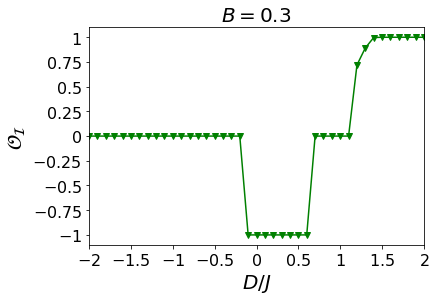

In [130]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.plot(data2['D_ext'], data2['O_I'], marker='v', c='g')
ax.set_xlabel(r"$D/J$", fontsize=20)
ax.set_ylabel(r"$\mathcal{O}_\mathcal{I}$", fontsize=20)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.set_xlim([-2, 2])
ax.set_title('$B=0.3$', fontsize=20)
plt.show()

This reproduces Fig. 4.(b) apart from the slight non-quantization on the last transition -- improving the quality of the density matrix renormalization group can remedy this. Try this if you have time. 

Most importantly, we can now see the emergence of an additional $\mathbb{Z}_2^y$ phase between the Haldane and large-$D$ phases.

## Figure 7

In the previous section, we identified symmetry protected topological phases using (among other quantifiers) the inversion order parameter. We worked with an infinite chain and utilized the generalized transfer matrix corresponding to the overlap of the inverted and original chains. In this section, we demonstrate how one can recover this result with partial reflections. We consider a chain matrix product state unit cell that is of length $L=32$. Initially, we invert the central $2$ sites and then take the overlap with the original chain. Then, we invert the central $4$ sites and take the overlap with the original chain, and so on. As we increase the size of the partial reflection, we approach the result of the full inversion studied above.

We consider a 32-site matrix product state unit cell, and compute $\langle \Psi | \mathcal{R}_\text{part} | \Psi\rangle$ as we increment the size of the refelected region.

WARNING: The following cell may take several minutes to run.

In [114]:
import numpy as np
import tenpy.linalg.np_conserved as npc

from tenpy.networks.mps import TransferMatrix
from tenpy.networks.site import SpinSite

from tenpy.networks.mps import MPS
from tenpy.algorithms import dmrg


data3 = dict(n=np.linspace(4, 30, 14), O_I_0=[], O_I_0_5=[], O_I_1_5=[])

model_params = dict(B=0.3, L=32)

dmrg_params = {
    'mixer': True, # setting this to True helps to escape local minima
    'mixer_params': {'amplitude': 1.e-5, 'decay': 1.2, 'disable_after': 30},
    'trunc_params': {
        # 'chi_max': 100,
        'svd_min': 1.e-10,
    },
    'lanczos_params': {
            # 'reortho': True,
            # 'N_cache': 40
            'cutoff': 1.e-13  # fixes theta=0 error
    },
    'chi_list': {0: 9, 10: 49, 20: 100, 40: 100},
    'max_E_err': 1.e-6,
    'max_S_err': 1.e-6,
    'max_sweeps': 1000,
    'verbose': 1.,
    'N_sweeps_check': 10,  # default=10
    'diag_method': 'default',
    'combine': True
}

prod_state = ['up', 'down']*16

eng = None
for D_ext in [0, 0.5, 1.5]:
    print("="*100)
    print("D_ext = ", D_ext)
    model_params['D'] = D_ext
    if eng is None:  # first time in the loop
        M = HeisenbergModel(model_params)
        psi = MPS.from_product_state(M.lat.mps_sites(), prod_state, bc=M.lat.bc_MPS)
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    else:
        del eng.options['chi_list']
        M = HeisenbergModel(model_params)
        eng.init_env(model=M)
    E, psi = eng.run()
    
    ### compute O_I
    
    for i in range(4, psi.L, 2):
        psi_t = psi.copy()
        lst = list(range(psi.L))
        print("lst = ", lst)
        perm_lst = [lst[0]] + lst[i:0:-1] + lst[i+1:]
        print("perm_lst = ", perm_lst)
        psi_t.permute_sites(perm_lst, swap_op='auto')
        overlap = psi.overlap(psi_t)
        trace_4 = np.sum(np.power(psi_t.get_SR(0), 4))
        if D_ext == 0:
            data3['O_I_0'].append(np.real(overlap)/trace_4)
        elif D_ext == 0.5:
            data3['O_I_0_5'].append(np.real(overlap)/trace_4)
        elif D_ext == 1.5:
            data3['O_I_1_5'].append(np.real(overlap)/trace_4)

D_ext =  0
Reading 'L'=32 for config HeisenbergModel
Reading 'B'=0.3 for config HeisenbergModel
Reading 'D'=0 for config HeisenbergModel
Reading 'combine'=True for config TwoSiteDMRGEngine
Subconfig 'lanczos_params'=Config(<2 options>, 'lanczos_params') for config TwoSiteDMRGEngine
Subconfig 'trunc_params'=Config(<2 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'chi_list'={0: 9, 10: 49, 20: 100, 40: 100} for config TwoSiteDMRGEngine
Setting chi_max = 9
Initial sweeps...
Updating environment
.
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'diag_method'='default' for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Setting chi_max = 49
Updating environment
.....
sweep 10, age 

lst =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
perm_lst =  [0, 8, 7, 6, 5, 4, 3, 2, 1, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config trunc

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
lst =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
perm_lst =  [0, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config trunc

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
lst =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

lst =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
perm_lst =  [0, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config trunc

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
lst =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
perm_lst =  [0, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Reading 'chi_max'=100 for config trunc

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
lst =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

lst =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
perm_lst =  [0, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config trunc

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

lst =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
perm_lst =  [0, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config trunc

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min'=None for config truncation
Reading 'degeneracy_tol'=None for config truncation
Reading 'svd_min'=1e-14 for config truncation
Reading 'trunc_cut'=1e-14 for config truncation
Reading 'chi_max'=100 for config truncation
Reading 'chi_min

We can then plot $\langle \Psi | \mathcal{R}_\text{part} | \Psi\rangle$ against the number of sites in the partial reflection $n$.

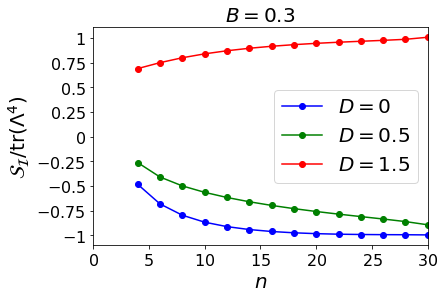

In [115]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.plot(data3['n'], data3['O_I_0'], marker='o', c='b', label='$D=0$')
ax.plot(data3['n'], data3['O_I_0_5'], marker='o', c='g', label='$D=0.5$')
ax.plot(data3['n'], data3['O_I_1_5'], marker='o', c='r', label='$D=1.5$')
ax.legend(loc='right', fontsize=20)
ax.set_xlabel(r"$n$", fontsize=20)
ax.set_ylabel(r"$\mathcal{S}_\mathcal{I}/\mathrm{tr}(\Lambda^4)$", fontsize=20)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.set_xlim([0, 30])
ax.set_title('$B=0.3$', fontsize=20)
plt.show()

This reproduces Fig. 7 and accords with our previous result.

## Extension: Many-body topological invariants for fermionic symmetry-protected topological phases

This extension reproduces some of the tensor network results from the paper: ["Many-body topological invariants for fermionic symmetry-protected topological phases" by Hassan Shapourian, Ken Shiozaki, and Shinsei Ryu, Physical Review Letters 118, 216402 (2017)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.118.216402), freely available at [arXiv:1607.03896 [cond-mat.str-el]](https://arxiv.org/abs/1607.03896).

The previous paper studied the detection of symmetry protected topological phases in 1D bosonic systems. Now, in this paper, we can extend these ideas to the detection of symmetry protected topological phases in 1D fermionic systems. To this end, we will employ the most recently-introduced indicator of partial reflections.

We aim to reproduce Fig. 5 in the appendix and consider the spinless Su-Schrieffer-Heeger model given by:

$$ H=-t_1 \sum_{j} \left( c^{L\dagger}_j c^R_j +\text{H.c.}\right) -t_2 \sum_{j} \left( c^{L\dagger}_{j+1} c^R_j +\text{H.c.}\right), $$

where $t_1$ and $t_2$ are the intra- and inter-dimer coupling strengths, respectively. When the model has exclusively $t_1$ hoppings then it is in the trivial/dimer limit, whereas when it has exclusively $t_2$ hoppings then it is in the topological limit.

We define the model such that it obeys the reflection symmetries $\mathcal{R}c_j^{L/R}\mathcal{R}^{-1}=c_{-j}^{R/L}$ and $\mathcal{R}c_{j}^{L/R}\mathcal{R}^{-1}=ic_{-j}^{R/L}$. As before, the paper demonstrates that in this case the partial reflection operator $\mathcal{R}_\mathrm{part}$ may be used as an order parameter, taking the form:

$$ \langle\mathcal{R}_\text{part}\rangle=\left(\prod_{j}\frac{1}{d_j}\right)e^{\mathrm{i}\theta}, $$

where $d$ is the quasiparticle quantum dimension and the $\theta$ is the phase corresponding to the symmetry protected topology classification.

First we define the Su-Schrieffer-Heeger model:

In [116]:
import numpy as np

from tenpy.models.model import CouplingMPOModel
from tenpy.networks.site import FermionSite
from tenpy.models.lattice import Chain


class SSHModel(CouplingMPOModel):

    def __init__(self, params):
        CouplingMPOModel.__init__(self, params)

    def init_sites(self, params):
        conserve = params.get('conserve', 'N')
        n = params.get('n', (1, 2))
        n = n[0] / n[1]
        site = FermionSite(conserve=conserve, filling=n)
        return site

    def init_lattice(self, params):
        L = params.get('L', 8)
        site = self.init_sites(params)
        lat = Chain(L, site, bc='periodic', bc_MPS='infinite')
        return lat

    def init_terms(self, params):
        t1 = params.get('t1', 1)
        t2 = params.get('t2', 1)

        self.add_coupling([np.conj(-t1), -t2], 0, 'Cd', 0, 'C', 1, plus_hc=True)

We proceed as before, with a $32$-site matrix product state unit cell. We use a partial reflection region of $16$ sites, which is sufficient to show the transition. In the paper, they take a $200$-site matrix product state unit cell with a $100$-site partial reflection region, which results in a sharper transition. 

Crucially, we now need to use the fermionic swap operator corresponding to $\mathcal{R}^2=-1$. Note that this swap operator is already defined in tenpy. We simply write it out here explicity, so that you can see how it differs from the trivial bosonic swap operator. The bond dimension of the swap operator is also important.

WARNING: The following cell may take several minutes to run.

In [117]:
import numpy as np
import tenpy.linalg.np_conserved as npc

from tenpy.networks.mps import TransferMatrix
from tenpy.networks.site import SpinSite

from tenpy.networks.mps import MPS
from tenpy.algorithms import dmrg


data4 = dict(t2_ext=np.linspace(0, 2, 21), mag=[], phase=[])

model_params = dict(t1=1, L=32)

dmrg_params = {
    'mixer': True, # setting this to True helps to escape local minima
    'mixer_params': {'amplitude': 1.e-5, 'decay': 1.2, 'disable_after': 30},
    'trunc_params': {
        # 'chi_max': 100,
        'svd_min': 1.e-10,
    },
    'lanczos_params': {
            # 'reortho': True,
            # 'N_cache': 40
            'cutoff': 1.e-13  # fixes theta=0 error
    },
    'chi_list': {0: 9, 10: 49, 20: 100, 40: 100},
    'max_E_err': 1.e-6,
    'max_S_err': 1.e-6,
    'max_sweeps': 1000,
    'verbose': 1.,
    'N_sweeps_check': 10,  # default=10
    'diag_method': 'default',
    'combine': True
}

prod_state = [0, 1, 0, 1] * int(32 / 4)

eng = None
for t2_ext in np.linspace(0, 2, 21):
    print("="*100)
    print("t2_ext = ", t2_ext)
    model_params['t2'] = t2_ext
    if eng is None:  # first time in the loop
        M = SSHModel(model_params)
        psi = MPS.from_product_state(M.lat.mps_sites(), prod_state, bc=M.lat.bc_MPS)
        eng = dmrg.TwoSiteDMRGEngine(psi, M, dmrg_params)
    else:
        del eng.options['chi_list']
        M = SSHModel(model_params)
        eng.init_env(model=M)
    E, psi = eng.run()
    
    ### compute O_I
    
    i = int(psi.L/2)
    
    psi_t = psi.copy()
    lst = list(range(psi.L))
    print("lst = ", lst)
    perm_lst = lst[0:2] + lst[i+1:1:-1] + lst[i+2:]  # subregion starts at site 2
    print("perm_lst = ", perm_lst)
    leg = psi.sites[0].leg
    swap_op = npc.Array.from_ndarray(np.diag([1., -1.j, -1.j, 1.]).reshape([2, 2, 2, 2]),
                                     [leg, leg, leg.conj(), leg.conj()], labels=['p1', 'p0', 'p0*', 'p1*'])
    psi_t.permute_sites(perm_lst, swap_op=swap_op, trunc_par={'chi_max': 100, 'verbose': 0})
    # psi_t.permute_sites(perm_lst, swap_op='autoInv', trunc_par={'chi_max': 100, 'verbose': 0})
    overlap = psi.overlap(psi_t)
    quantity = np.imag(np.log(overlap)) / (np.pi / 4)
    data4['mag'].append(abs(overlap))
    data4['phase'].append(quantity)

t2_ext =  0.0
Reading 'L'=32 for config SSHModel
Reading 't1'=1 for config SSHModel
Reading 't2'=0.0 for config SSHModel
Reading 'combine'=True for config TwoSiteDMRGEngine
Subconfig 'lanczos_params'=Config(<2 options>, 'lanczos_params') for config TwoSiteDMRGEngine
Subconfig 'trunc_params'=Config(<2 options>, 'trunc_params') for config TwoSiteDMRGEngine
Reading 'chi_list'={0: 9, 10: 49, 20: 100, 40: 100} for config TwoSiteDMRGEngine
Setting chi_max = 9
Initial sweeps...
Updating environment
.
Reading 'N_sweeps_check'=10 for config TwoSiteDMRGEngine
Reading 'max_sweeps'=1000 for config TwoSiteDMRGEngine
Reading 'max_E_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'max_S_err'=1e-06 for config TwoSiteDMRGEngine
Reading 'diag_method'='default' for config TwoSiteDMRGEngine
Reading 'mixer'=True for config TwoSiteDMRGEngine
Subconfig 'mixer_params'=Config(<4 options>, 'mixer_params') for config TwoSiteDMRGEngine
Setting chi_max = 49
Updating environment
.....
sweep 10, age = 1056
Energy = 

/home/bart/TeNPy/tenpy/algorithms/mps_sweeps.py:196: UserWarning: The leg of the new model is incompatible with the previous one.Rebuild environment from scratch.
  warnings.warn("The leg of the new model is incompatible with the previous one."


.


/home/bart/TeNPy/tenpy/linalg/lanczos.py:250: UserWarning: Poorly conditioned Lanczos!
  warnings.warn("Poorly conditioned Lanczos!")


Updating environment
.....
sweep 10, age = 1056
Energy = -0.5012507832108390, S = nan, norm_err = 4.0e-15
Current memory usage 375.0 MB, time elapsed: 37.2 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.0297e-19, max_E_trunc = 2.2169e-12
MPS bond dimensions: [12, 15, 12, 17, 17, 22, 20, 22, 21, 23, 19, 23, 22, 22, 19, 22, 23, 24, 22, 26, 22, 21, 21, 24, 22, 21, 20, 22, 21, 24, 20, 19]
Updating environment
.....
sweep 20, age = 2016
Energy = -0.5012507832108888, S = nan, norm_err = 3.8e-15
Current memory usage 375.0 MB, time elapsed: 61.7 s
Delta E = -4.9738e-15, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.7410e-20, max_E_trunc = 9.0949e-13
MPS bond dimensions: [10, 14, 11, 17, 20, 23, 22, 24, 20, 24, 21, 24, 21, 24, 22, 26, 20, 24, 20, 22, 21, 26, 21, 24, 19, 23, 20, 25, 21, 22, 18, 18]
disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 2976
Energy = -0.5012507832108142, S = 0.3518360035820488, norm_err = 2.6e-

Updating environment
.....
sweep 40, age = 13664
Energy = -0.5113147574616193, S = 0.3829272772420461, norm_err = 4.4e-15
Current memory usage 375.0 MB, time elapsed: 67.4 s
Delta E = -4.9738e-14, Delta S = -3.5438e-14 (per sweep)
max_trunc_err = 9.9771e-20, max_E_trunc = 6.3665e-12
MPS bond dimensions: [34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42]
Updating environment
.....
sweep 50, age = 14624
Energy = -0.5113147574617045, S = 0.3829272772422140, norm_err = 4.4e-15
Current memory usage 375.0 MB, time elapsed: 77.3 s
Delta E = -8.5265e-15, Delta S = 1.6787e-14 (per sweep)
max_trunc_err = 9.9772e-20, max_E_trunc = 8.1855e-12
MPS bond dimensions: [34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42, 34, 42]
DMRG finished after 50 sweeps.
total size = 14624, maximum chi = 42
lst =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,

t2_ext =  0.6000000000000001
Reading 'explicit_plus_hc'=False for config SSHModel
Reading 'L'=32 for config SSHModel
Reading 'conserve'='N' for config SSHModel
Reading 'n'=(1, 2) for config SSHModel
Reading 't1'=1 for config SSHModel
Reading 't2'=0.6000000000000001 for config SSHModel
Reading 'sort_mpo_legs'=False for config SSHModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 25376
Energy = -0.5461192917796893, S = nan, norm_err = 7.5e-15
Current memory usage 375.0 MB, time elapsed: 29.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 2.5547e-18, max_E_trunc = 2.3647e-11
MPS bond dimensions: [62, 66, 58, 80, 87, 80, 80, 81, 88, 84, 82, 80, 83, 78, 83, 80, 87, 82, 82, 81, 85, 80, 81, 78, 83, 83, 79, 82, 89, 81, 83, 84]
Updating environment
.....
sweep 20, age = 26336
Energy = -0.5461192917796325, S = nan, norm_err = 7.1e-15
Current memory usage 375.0 MB, time elapsed: 54.3 s
Delta E = 5.6843e-15, Delta S = 0.0000e+00 (per sweep)

.....
sweep 20, age = 36064
Energy = -0.5839047542636990, S = nan, norm_err = 8.3e-15
Current memory usage 375.0 MB, time elapsed: 52.7 s
Delta E = -1.5916e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.1573e-14, max_E_trunc = 4.0018e-11
MPS bond dimensions: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 37024
Energy = -0.5839047542590947, S = 0.6015234958053322, norm_err = 2.3e-14
Current memory usage 375.0 MB, time elapsed: 71.4 s
Delta E = 4.6043e-13, Delta S = nan (per sweep)
max_trunc_err = 3.1788e-14, max_E_trunc = 4.7294e-11
MPS bond dimensions: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 40, age = 37984
Energy = 

Updating environment
.....
sweep 40, age = 47712
Energy = -0.6366190371468292, S = 1.4291514498818367, norm_err = 1.1e-06
Current memory usage 375.0 MB, time elapsed: 99.6 s
Delta E = 9.4360e-12, Delta S = 4.9621e-05 (per sweep)
max_trunc_err = 7.0067e-08, max_E_trunc = 2.8079e-07
MPS bond dimensions: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 50, age = 48672
Energy = -0.6366190371328457, S = 1.4292912084937255, norm_err = 5.0e-07
Current memory usage 375.0 MB, time elapsed: 113.3 s
Delta E = 1.3983e-12, Delta S = 1.3976e-05 (per sweep)
max_trunc_err = 7.0138e-08, max_E_trunc = 2.8108e-07
MPS bond dimensions: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 60, age = 49632
Energy = -0.6366190371

DMRG finished after 70 sweeps.
total size = 60256, maximum chi = 100
lst =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
perm_lst =  [0, 1, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
t2_ext =  1.2000000000000002
Reading 'explicit_plus_hc'=False for config SSHModel
Reading 'L'=32 for config SSHModel
Reading 'conserve'='N' for config SSHModel
Reading 'n'=(1, 2) for config SSHModel
Reading 't1'=1 for config SSHModel
Reading 't2'=1.2000000000000002 for config SSHModel
Reading 'sort_mpo_legs'=False for config SSHModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 61280
Energy = -0.7098096374552370, S = nan, norm_err = 8.4e-15
Current memory usage 375.0 MB, time elapsed: 22.9 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.4898e-13, max_E_trunc = 6.5484e-11
MPS bond dimensions: [100, 100, 100, 

.
Updating environment
.....
sweep 10, age = 71008
Energy = -0.7925941500334375, S = nan, norm_err = 7.7e-15
Current memory usage 375.0 MB, time elapsed: 23.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 5.7530e-16, max_E_trunc = 1.0186e-10
MPS bond dimensions: [75, 79, 74, 93, 91, 90, 92, 95, 95, 93, 91, 91, 88, 92, 92, 91, 89, 94, 95, 92, 93, 92, 92, 90, 92, 91, 93, 91, 93, 91, 93, 89]
Updating environment
.....
sweep 20, age = 71968
Energy = -0.7925941500328690, S = nan, norm_err = 7.2e-15
Current memory usage 375.0 MB, time elapsed: 46.0 s
Delta E = 5.6843e-14, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.0455e-16, max_E_trunc = 7.2760e-11
MPS bond dimensions: [75, 78, 74, 91, 93, 91, 92, 88, 92, 93, 97, 92, 92, 87, 94, 88, 90, 93, 94, 90, 92, 89, 93, 92, 91, 92, 91, 88, 92, 93, 91, 94]
disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 72928
Energy = -0.7925941500217277, S = 0.5379288105544933, norm_err = 1

.....
sweep 30, age = 82656
Energy = -0.8802540610995493, S = 0.4892315777210658, norm_err = 7.9e-15
Current memory usage 375.0 MB, time elapsed: 71.9 s
Delta E = 5.3433e-13, Delta S = nan (per sweep)
max_trunc_err = 9.4058e-18, max_E_trunc = 7.2760e-11
MPS bond dimensions: [97, 98, 97, 99, 98, 99, 98, 98, 99, 95, 99, 100, 98, 97, 99, 97, 99, 97, 98, 99, 98, 99, 98, 97, 98, 95, 100, 96, 99, 97, 99, 95]
Updating environment
.....
sweep 40, age = 83616
Energy = -0.8802540611033010, S = 0.4892315777182696, norm_err = 6.8e-15
Current memory usage 375.0 MB, time elapsed: 85.6 s
Delta E = -3.7517e-13, Delta S = -2.7962e-13 (per sweep)
max_trunc_err = 4.0292e-18, max_E_trunc = 5.0932e-11
MPS bond dimensions: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
Updating environment
.....
sweep 50, age = 84576
Energy = -0.8802540611061431, S = 0.4892315777199474, norm_err = 6.7e-15
Curren

DMRG finished after 50 sweeps.
total size = 94304, maximum chi = 100
lst =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
perm_lst =  [0, 1, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
t2_ext =  1.9000000000000001
Reading 'explicit_plus_hc'=False for config SSHModel
Reading 'L'=32 for config SSHModel
Reading 'conserve'='N' for config SSHModel
Reading 'n'=(1, 2) for config SSHModel
Reading 't1'=1 for config SSHModel
Reading 't2'=1.9000000000000001 for config SSHModel
Reading 'sort_mpo_legs'=False for config SSHModel
Initial sweeps...
Updating environment
.
Updating environment
.....
sweep 10, age = 95328
Energy = -1.0170172793776828, S = nan, norm_err = 6.3e-15
Current memory usage 375.0 MB, time elapsed: 26.8 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 1.8389e-19, max_E_trunc = 1.0914e-10
MPS bond dimensions: [45, 49, 46, 57,

/home/bart/TeNPy/tenpy/linalg/lanczos.py:250: UserWarning: Poorly conditioned Lanczos!
  warnings.warn("Poorly conditioned Lanczos!")


Updating environment
.....
sweep 10, age = 100192
Energy = -1.0635444099816596, S = nan, norm_err = 5.7e-15
Current memory usage 375.0 MB, time elapsed: 27.4 s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 6.5142e-20, max_E_trunc = 7.2760e-11
MPS bond dimensions: [43, 47, 43, 61, 61, 57, 59, 60, 59, 57, 59, 57, 59, 55, 59, 59, 61, 61, 59, 56, 58, 60, 62, 55, 60, 57, 58, 59, 59, 58, 61, 57]
Updating environment
.....
sweep 20, age = 101152
Energy = -1.0635444099880260, S = nan, norm_err = 6.2e-15
Current memory usage 375.0 MB, time elapsed: 53.9 s
Delta E = -6.3665e-13, Delta S = 0.0000e+00 (per sweep)
max_trunc_err = 3.5222e-18, max_E_trunc = 1.6007e-10
MPS bond dimensions: [44, 49, 46, 56, 59, 57, 59, 58, 59, 57, 59, 58, 60, 57, 60, 57, 63, 58, 58, 59, 59, 56, 59, 57, 58, 60, 60, 57, 60, 58, 59, 58]
disable mixer after 30 sweeps, final amplitude 4.21e-08
Updating environment
.....
sweep 30, age = 102112
Energy = -1.0635444099782490, S = 0.4383367377445651, norm_err =

Finally, we can plot the magnitude and phase of $\langle \mathcal{R}_\mathrm{part} \rangle$ as we vary $t_2/t_1$ to interpolate between trivial and topological limits, and reproduce Fig. 5 from the appendix.

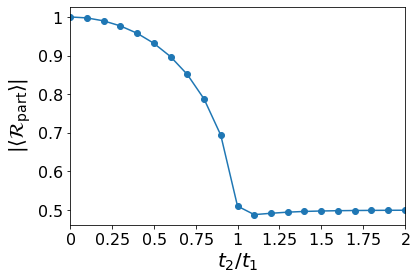

In [118]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.plot(data4['t2_ext'], data4['mag'], marker='o')
ax.set_xlabel(r"$t_2/t_1$", fontsize=20)
ax.set_ylabel(r"$|\langle \mathcal{R}_\mathrm{part}\rangle|$", fontsize=20)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.set_xlim([0, 2])
plt.show()

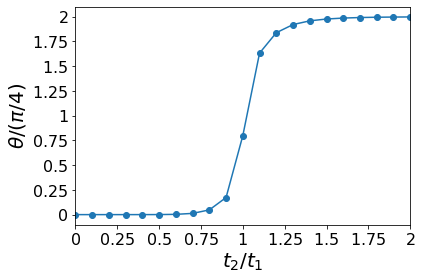

In [119]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax = plt.gca()
ax.plot(data4['t2_ext'], data4['phase'], marker='o')
ax.set_xlabel(r"$t_2/t_1$", fontsize=20)
ax.set_ylabel(r"$\theta / (\pi/4)$", fontsize=20)
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%g$'))
ax.set_xlim([0, 2])

plt.show()

In the trivial region, we notice that the phase is zero and the magnitude takes a value less than or equal to one. In the topological region, however, we obtain a magnitude of $1/2$, which corresponds to two Majorana fermions at each end of the chain with quantum dimension $\sqrt{2}$, and a phase of $\pi/2$, which corresponds to a symmetry protected topology with a $\mathbb{Z}_4$ classification.

If you have any questions about this tutorial, please e-mail Bartholomew Andrews at bartandrews123@gmail.com